# Analysis of AirBnB Listings

### Import packages

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib as mpl
%matplotlib inline
from matplotlib.colors import TwoSlopeNorm

### Gather the data

In [ ]:
# Importing the datasets
# Assigning low_memory to False prevents errors in reading the data from .csv
jun_20_source = pd.read_csv("listings_jun_20.csv", low_memory=False)
apr_21_source = pd.read_csv("listings_apr_21.csv", low_memory=False)

# Select the relevant columns
jun_20 = jun_20_source[['id', 'host_id', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type']]
apr_21 = apr_21_source[['id', 'host_id', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type']]

# View the data
jun_20.head()

,id,host_id,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type
0,11551,43039,Brixton,Lambeth,NaN,Apartment,Entire home/apt
1,13913,54730,LB of Islington,Islington,NaN,Apartment,Private room
2,15400,60302,Chelsea,Kensington and Chelsea,NaN,Apartment,Entire home/apt
3,17402,67564,City of Westminster,Westminster,NaN,Apartment,Entire home/apt
4,17506,67915,LB of Hammersmith & Fulham,Hammersmith and Fulham,NaN,Bed and breakfast,Private room


In [ ]:
apr_21.head()

,id,host_id,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type
0,11551,43039,"London, United Kingdom",Lambeth,NaN,Entire apartment,Entire home/apt
1,13913,54730,"Islington, Greater London, United Kingdom",Islington,NaN,Private room in apartment,Private room
2,15400,60302,"London, United Kingdom",Kensington and Chelsea,NaN,Entire apartment,Entire home/apt
3,17402,67564,"London, Fitzrovia, United Kingdom",Westminster,NaN,Entire apartment,Entire home/apt
4,17506,67915,"London, United Kingdom",Hammersmith and Fulham,NaN,Private room in townhouse,Private room


In [ ]:
# Check the shape of the DataFrames
print("jun_20 shape =", jun_20.shape)
print("apr_21 shape =", apr_21.shape)

jun_20 shape = (83711, 7)
apr_21 shape = (74840, 7)


### Assess the data

In [ ]:
# Assessing the prevalence of missing values
nulls_jun_20 = jun_20.isnull().sum() / jun_20.shape[0]
nulls_apr_21 = apr_21.isnull().sum() / apr_21.shape[0]

nulls_jun_20

id                              0.0
host_id                         0.0
neighbourhood                   0.0
neighbourhood_cleansed          0.0
neighbourhood_group_cleansed    1.0
property_type                   0.0
room_type                       0.0
dtype: float64

In [ ]:
nulls_apr_21

id                              0.000000
host_id                         0.000000
neighbourhood                   0.393346
neighbourhood_cleansed          0.000000
neighbourhood_group_cleansed    1.000000
property_type                   0.000000
room_type                       0.000000
dtype: float64

In [ ]:
# Check that the id columns contain only unique elements
print(len(jun_20['id']) == len(set(jun_20['id'])))
print(len(apr_21['id']) == len(set(apr_21['id'])))

### They do contain all unique elements

True
True


### Clean the data

In [ ]:
# The neighbourhood_cleansed column is sufficient for my analysis
# The neighbourhood column is in an inconsistent format in apr_21
# The neighbourhood_group_cleansed column has 100% missing values
# Given the above, we will keep only the neighbourhood_cleansed column

def drop_columns(df, columns=[]):
    '''
    INPUT:
    df = pandas DataFrame
    columns = list of columns to drop, default is an empty list
    
    OUTPUT:
    df = pandas DataFrame, with columns dropped
    
    description:
    This function takes in a DataFrame and drops any columns that
    are all missing values and any columns in the columns list inputted.
    '''
    df = df.dropna(axis=1, how='all')
    df = df.drop(columns=columns)
    return df

columns = ['neighbourhood']
jun_20 = drop_columns(jun_20, columns)
apr_21 = drop_columns(apr_21, columns)

In [ ]:
# Check that the function had the intended result
jun_20.head()

,id,host_id,neighbourhood_cleansed,property_type,room_type
0,11551,43039,Lambeth,Apartment,Entire home/apt
1,13913,54730,Islington,Apartment,Private room
2,15400,60302,Kensington and Chelsea,Apartment,Entire home/apt
3,17402,67564,Westminster,Apartment,Entire home/apt
4,17506,67915,Hammersmith and Fulham,Bed and breakfast,Private room


In [ ]:
apr_21.head()

,id,host_id,neighbourhood_cleansed,property_type,room_type
0,11551,43039,Lambeth,Entire apartment,Entire home/apt
1,13913,54730,Islington,Private room in apartment,Private room
2,15400,60302,Kensington and Chelsea,Entire apartment,Entire home/apt
3,17402,67564,Westminster,Entire apartment,Entire home/apt
4,17506,67915,Hammersmith and Fulham,Private room in townhouse,Private room


In [ ]:
# Check that there are no more missing values
print(np.sum(jun_20.isnull().sum()))
print(np.sum(apr_21.isnull().sum()))

0
0


## Question 1: Leavers and joiners of the AirBnB platform

In [ ]:
# Net change in properties listed
net_change = apr_21.shape[0] - jun_20.shape[0]
net_change

-8871

In [ ]:
# Overall net change is negative, meaning more properties have left the 
# site than joined since June 2020.
# We should decompose this change into number of new joiners and leavers

# Set of all properties in June 2020 and in April 2021
in_jun_20 = set(jun_20['id'])
in_apr_21 = set(apr_21['id'])
all_ids = in_jun_20.union(in_apr_21)
print("Total number of properties:", len(all_ids))

# Set of properties listed in both June 2020 and April 2021
in_both = in_jun_20.intersection(in_apr_21)
print("Number of properties in both:", len(in_both))

# Set of properties only listed in June 2020 (i.e. leavers)
only_in_jun_20 = all_ids - in_apr_21
print("Number of properties only listed in June 2020:", len(only_in_jun_20))

# Set of properties only listed in April 2021 (i.e. new joiners)
only_in_apr_21 = all_ids - in_jun_20
print("Number of properties only listed in April 2021:", len(only_in_apr_21))

# Check it adds up
print("Add check:", in_both.union(only_in_jun_20, only_in_apr_21) == all_ids)

# Check it matches net change
print("Net change check:", len(only_in_apr_21) - len(only_in_jun_20) == net_change)

Total number of properties: 97648
Number of properties in both: 60903
Number of properties only listed in June 2020: 22808
Number of properties only listed in April 2021: 13937
Add check: True
Net change check: True


In [ ]:
# Visualisation for question 1
# Source for waterfall charts: https://plotly.com/python/waterfall-charts/
fig1 = go.Figure(go.Waterfall(
    name = "20", orientation = "v",
    measure = ["absolute", "relative", "relative", "total"],
    x = ["June 2020", "Leavers", "New joiners", "April 2021"],
    y = [len(in_jun_20), -len(only_in_jun_20), len(only_in_apr_21), len(in_apr_21)],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig1.update_layout(
        title = "Movements in AirBnB listings",
        yaxis_range=[0,90000]
)

fig1.show()

## Question 2: Private rooms vs entire properties

In [ ]:
# First, look at the types of room we have available
jun_20.groupby('room_type').count()

,id,host_id,neighbourhood_cleansed,property_type
room_type,,,,
Entire home/apt,46712,46712,46712,46712
Hotel room,745,745,745,745
Private room,35592,35592,35592,35592
Shared room,662,662,662,662


In [ ]:
# The main room types are entire homes or private rooms; we will focus on these
# Separate out the datasets by room type
room_jun_20 = jun_20[jun_20['room_type'] == 'Private room']
room_apr_21 = apr_21[apr_21['room_type'] == 'Private room']
home_jun_20 = jun_20[jun_20['room_type'] == 'Entire home/apt']
home_apr_21 = apr_21[apr_21['room_type'] == 'Entire home/apt']

In [ ]:
# Repeating the above analysis for private rooms only
# I will express each variable as a percentage of the June 2020 set for easier comparison
# Set of all properties in June 2020 and in April 2021
room_in_jun_20_ids = set(room_jun_20['id'])
room_in_apr_21_ids = set(room_apr_21['id'])
room_in_jun_20 = 1
room_in_apr_21 = len(room_in_apr_21_ids) / len(room_in_jun_20_ids)
room_all_ids = room_in_jun_20_ids.union(room_in_apr_21_ids)
print("Total number of properties:", len(room_all_ids) / len(room_in_jun_20_ids))

# Set of properties listed in both June 2020 and April 2021
room_in_both = len(room_in_jun_20_ids.intersection(room_in_apr_21_ids)) / len(room_in_jun_20_ids)
print("Number of properties in both:", room_in_both)

# Set of properties only listed in June 2020 (i.e. leavers)
room_only_in_jun_20_ids = room_all_ids - room_in_apr_21_ids
room_only_in_jun_20 = len(room_only_in_jun_20_ids) / len(room_in_jun_20_ids) 
print("Number of properties only listed in June 2020:", room_only_in_jun_20)

# Set of properties only listed in April 2021 (i.e. new joiners)
room_only_in_apr_21_ids = room_all_ids - room_in_jun_20_ids
room_only_in_apr_21 = len(room_only_in_apr_21_ids) / len(room_in_apr_21_ids) 
print("Number of properties only listed in April 2021:", room_only_in_apr_21)

# Check it adds up
print("Add check:", (room_in_both + room_only_in_jun_20 + room_only_in_apr_21) - len(room_all_ids) <0.0001)


Total number of properties: 1.1543324342548886
Number of properties in both: 0.7763542369071702
Number of properties only listed in June 2020: 0.22364576309282985
Number of properties only listed in April 2021: 0.16582641509433962
Add check: True


In [ ]:
# Repeating the above analysis for entire homes only
# I will express each variable as a percentage of the June 2020 set for easier comparison
# Set of all properties in June 2020 and in April 2021
home_in_jun_20_ids = set(home_jun_20['id'])
home_in_apr_21_ids = set(home_apr_21['id'])
home_in_jun_20 = 1
home_in_apr_21 = len(home_in_apr_21_ids) / len(home_in_jun_20_ids)
home_all_ids = home_in_jun_20_ids.union(home_in_apr_21_ids)
print("Total number of properties:", len(home_all_ids) / len(home_in_jun_20_ids))

# Set of properties listed in both June 2020 and April 2021
home_in_both = len(home_in_jun_20_ids.intersection(home_in_apr_21_ids)) / len(home_in_jun_20_ids)
print("Number of properties in both:", home_in_both)

# Set of properties only listed in June 2020 (i.e. leavers)
home_only_in_jun_20_ids = home_all_ids - home_in_apr_21_ids
home_only_in_jun_20 = len(home_only_in_jun_20_ids) / len(home_in_jun_20_ids) 
print("Number of properties only listed in June 2020:", home_only_in_jun_20)

# Set of properties only listed in April 2021 (i.e. new joiners)
home_only_in_apr_21_ids = home_all_ids - home_in_jun_20_ids
home_only_in_apr_21 = len(home_only_in_apr_21_ids) / len(home_in_apr_21_ids) 
print("Number of properties only listed in April 2021:", home_only_in_apr_21)

# Check it adds up
print("Add check:", (home_in_both + home_only_in_jun_20 + home_only_in_apr_21) - len(home_all_ids) <0.0001)

Total number of properties: 1.184898955300565
Number of properties in both: 0.6846206542216133
Number of properties only listed in June 2020: 0.3153793457783867
Number of properties only listed in April 2021: 0.21264495162124233
Add check: True


In [ ]:
# Visualisation for question 2
fig2 = go.Figure()

fig2.add_trace(go.Waterfall(
    x = ["June 2020", "Leavers", "New joiners", "April 2021"],
    y = [room_in_jun_20, -room_only_in_jun_20, room_only_in_apr_21, room_in_apr_21],
    measure = ["absolute", "relative", "relative", "total"],
    name = "Private rooms"
))

fig2.add_trace(go.Waterfall(
    x = ["June 2020", "Leavers", "New joiners", "April 2021"],
    y = [home_in_jun_20, -home_only_in_jun_20, home_only_in_apr_21, home_in_apr_21],
    measure = ["absolute", "relative", "relative", "total"],
    decreasing = {"marker":{"color":"Maroon"}},
    increasing = {"marker":{"color":"Teal"}},
    totals = {"marker":{"color":"Royalblue"}},
    name = "Entire homes"
))

fig2.update_layout(
    title = "Movements in AirBnB listings: by room type",
    waterfallgroupgap = 0.5
)

fig2.show()

## Question 3: Boroughs

In [ ]:
# Calculating the net change in listings as a percentage of the number 
# of June 2020 listings in each borough
boroughs_apr_21 = apr_21.groupby('neighbourhood_cleansed').count()['id']
boroughs_jun_20 = jun_20.groupby('neighbourhood_cleansed').count()['id']
boroughs_net_change = (boroughs_apr_21 - boroughs_jun_20) / boroughs_jun_20
boroughs_df = pd.DataFrame(boroughs_net_change)
boroughs_df.columns = ['Net_change']
boroughs_df

,Net_change
neighbourhood_cleansed,
Barking and Dagenham,0.023077
Barnet,-0.031972
Bexley,0.057252
Brent,-0.082805
Bromley,-0.125776
Camden,-0.147686
City of London,-0.101075
Croydon,-0.007220
Ealing,-0.062217


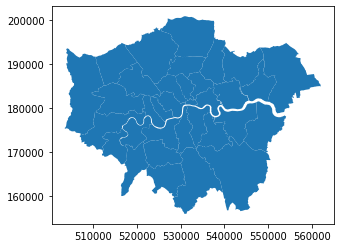

In [ ]:
# Source for this geodata: https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london
# Importing the geodata of London boroughs to be used
shapefile = "London_Borough_Excluding_MHW.shp"
map_df = gpd.read_file(shapefile)
map_df.plot();

In [ ]:
# Source for the visualisation code: https://www.lifebysummer.com/post/mapping-with-python-part-1
# Merging the geodata with the data on net change in boroughs
merged = map_df.set_index('NAME').join(boroughs_df)
merged.head()

,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,Net_change
NAME,,,,,,,,
Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16...",-0.037838
Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15...",-0.007220
Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15...",-0.125776
Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17...",-0.040187
Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18...",-0.062217


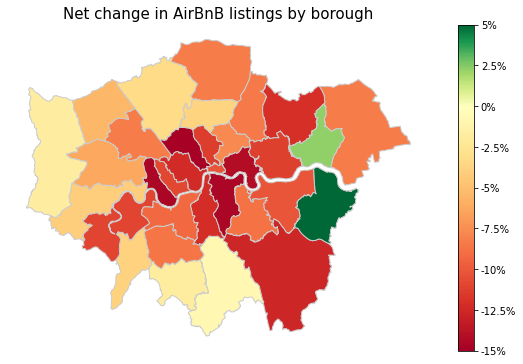

In [ ]:
# Setting the column I want to display
v = 'Net_change'

# Setting the normalisation
vmax, vmin, vcenter = 0.05,-0.15,0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# Setting up the plot
fig, ax = plt.subplots(1,figsize=(10,6))
merged.plot(column=v, cmap='RdYlGn', norm=norm, legend=False, ax=ax, edgecolor='0.8')

# Setting the axis settings and title
ax.axis('off')
ax.set_title('Net change in AirBnB listings by borough', fontdict={'fontsize': '15'})

# Setting up the colour bar
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=norm)
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.set_yticklabels(['-15%', '-12.5%', '-10%','-7.5%','-5%','-2.5%','0%','2.5%','5%']) ;